# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels 

In [2]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 10

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1.0
params['c_u'] = 1e-3

In [3]:
from scipy.linalg import solve

def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl) - 1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    y = np.zeros((num_samples, num_classes))
    labeled_idx = np.where(Y != 0)[0]
    unlabeled_idx = np.where(Y == 0)[0]
    
    for i in labeled_idx:
        y[i, int(Y[i]-1)] = 1
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        L_SS = L[np.ix_(labeled_idx, labeled_idx)]
        L_ST = L[np.ix_(labeled_idx, unlabeled_idx)]
        L_TS = L[np.ix_(unlabeled_idx, labeled_idx)]
        L_TT = L[np.ix_(unlabeled_idx, unlabeled_idx)]
        f_S = y[labeled_idx, :]
        f_T = np.linalg.solve(L_TT, - np.dot(L_TS, f_S))
        f = y.copy()
        f[unlabeled_idx, :] = f_T

    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        n = num_samples
        c_l = params.get('c_l', 1.0)
        c_u = params.get('c_u', 1e-3)
        c = np.array([c_l if i in labeled_idx else c_u for i in range(n)])
        C = np.diag(c)
        C_inv = np.diag(1 / c)
        A = np.dot(C_inv, L) + np.eye(n)
        f = np.linalg.solve(A, y)

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1
    return labels, f


In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. (Try the larger dataset at home.)
    data_path = os.path.join('data', dataset)
    in_data = loadmat(data_path)
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)
    
    num_samples = Y.shape[0]
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # Mask labels: Only l labeled examples will be revealed.
    Y_masked = mask_labels(Y, l)
    
    # To ensure that both classes are represented, check:
    if len(np.unique(Y_masked)) <= 2:
        raise ValueError("only one class in training data!")
    
    # Introduce noise into the labeled set.
    # (Select l_noisy indices among the labeled ones and randomly assign one of the valid classes.)
    noise_indices = np.where(Y_masked != 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes[unique_classes != 0], l_noisy)
    
    # --- Build Graph Laplacian ---
    # If a regularization parameter is set (>0), one can use a regularized Laplacian.
    if params['laplacian_regularization'] > 0:
        L = build_laplacian_regularized(X, var=params['var'], eps=params['eps'], 
                                        k=params['k'], laplacian_normalization=params['laplacian_normalization'],
                                        laplacian_regularization=params['laplacian_regularization'])
    else:
        # Build similarity graph (W) and then Laplacian L.
        W = build_similarity_graph(X, var=params['var'], eps=params['eps'], k=params['k'])
        L = build_laplacian(W, laplacian_normalization=params['laplacian_normalization'])
    
    # Compute HFS solution.
    labels, f = compute_hfs(L, Y_masked, soft=soft, **params)
    
    # Visualize results.
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == Y.squeeze())
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

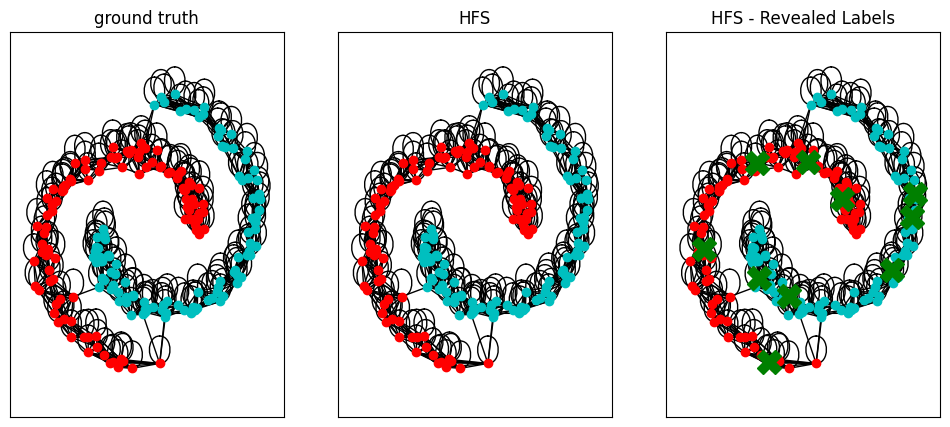

Soft=True, Accuracy=1.0


In [5]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=True, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

When running `two_moons_hfs` several times with a very small number of labeled examples (l=4) on the larger dataset, there's a risk that not all classes are represented in the labeled set. In our implementation, after applying the `mask_labels` function, we check whether the number of represented classes is greater than 2 (i.e., that both nonzero labels appear). If this condition is not met, the function raises an error (for example, "only one class in training data!") and the algorithm fails. This safeguard ensures that the HFS algorithm has at least one labeled example per class, which is crucial for proper label propagation.

In [6]:
mask_labels?

Signature: mask_labels(Y, l, per_class=False)
Docstring:
Function to select a subset of labels and mask the rest.

Parameters
----------
Y : array
    (n,) label vector, where entries Y_i take a value in [1, ..., C] , where C is the number of classes

l : int
    Number of unmasked (revealed) labels to include in the output.

per_class: bool, default: False
    If true, reveal l labels per class, instead of l labels in total.

Returns
-------
Y_masked : array
    (n,) masked label vector, where entries Y_i take a value in [1, ..., C]
    if the node is labeled, or 0 if the node is unlabeled (masked)               
File:      d:\documents\scolaires\mva\graphs\practicals\02_semi_supervised_learning\semi_supervised_learning\helper.py
Type:      function

In [7]:
np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
#mask_labels?  # check parameters

ValueError: only one class in training data!

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

  - **Hard HFS:** Accuracy = **73.5%**  
- **Soft HFS:** Accuracy = **64.5%**  

#### **Analysis:**  
- **Hard HFS** performs better due to strict constraints on labeled nodes, which works well with limited but mostly correct labels.  
- **Soft HFS**, using regularization, is more **robust to noisy labels**, but here, with only 5 noisy labels, it performs worse.  

#### **Conclusion:**  
- **Hard HFS:** Better with few, reliable labels.  
- **Soft HFS:** More robust with increased label noise.  

This highlights the **trade-off between consistency (Hard) and noise robustness (Soft)** in **semi-supervised learning (SSL)**.

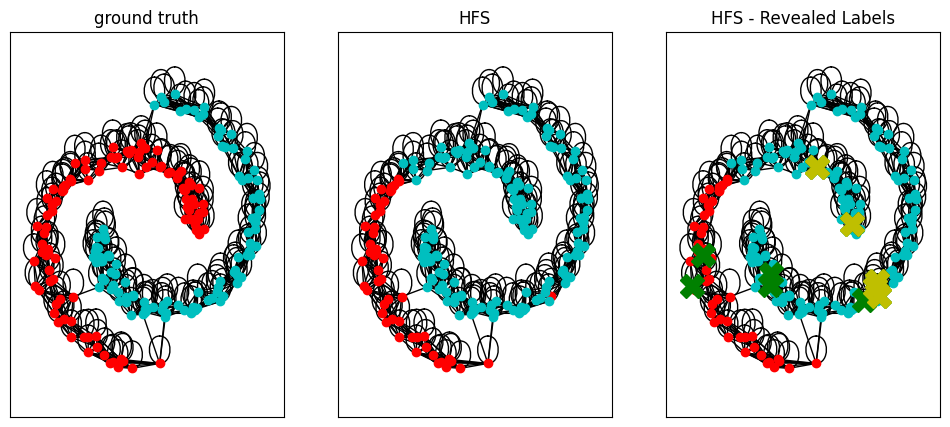

Soft=False, Accuracy=0.735


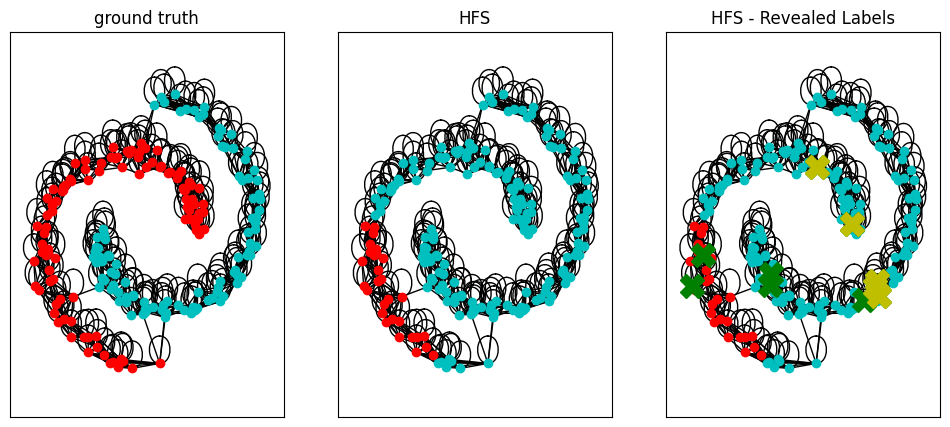

Soft=True, Accuracy=0.645


In [18]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

- **Approach**:
We extend the HFS method to handle multiple classes by converting the label vector into a one-hot encoded matrix.

- **How It Works**:
Each labeled example is represented as a one-hot vector (e.g., for 3 classes, class 1 → [1, 0, 0], class 2 → [0, 1, 0], etc.). The HFS algorithm then propagates these multi-dimensional targets over the graph, naturally handling more than two classes.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

#### Small Dataset (10 images per person):

- Best Accuracy: 81% (k = 2, c_l = 1.0, c_u = 1e-3)

#### Augmented Dataset (50 images per person):

- Best Accuracy: 63% (k = 10, c_l = 1.0, c_u = 1e-3)

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

#### Why Does Accuracy Drop with More Faces?  

The accuracy drops from **81% (small dataset)** to **63% (augmented dataset)** due to:  

- **Higher Intra-Class Variability:** More faces introduce differences in pose, lighting, and expression, making classification harder.  
- **Hyperparameter Sensitivity:** Parameters tuned for a small dataset may not generalize well to a larger, more complex set.  
- **Increased Noise:** More data doesn’t always mean better data—some images may be less representative or lower quality.  
- **Graph Construction Challenges:** A larger dataset makes it harder to build a clean similarity graph, leading to label propagation errors.  

**Conclusion:** More data can hurt performance if not properly handled. Better feature extraction and parameter tuning are needed to leverage the extra samples.

In [5]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [6]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = 2
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 1.0
params_face_rec['c_u'] = 1e-3

In [7]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float64)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

## 10 images per person

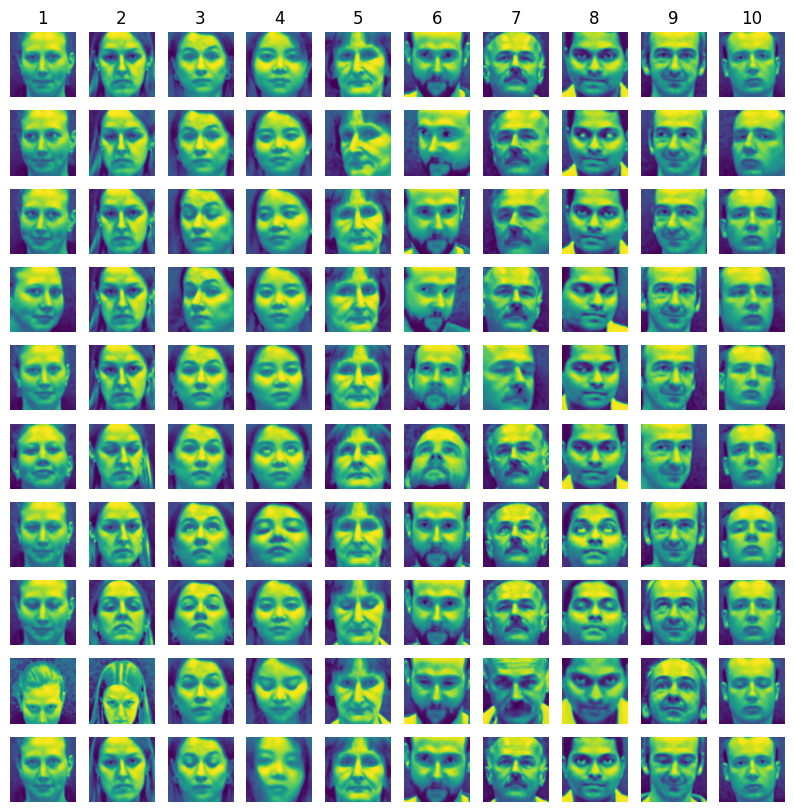

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [11]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [12]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.81
[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.  1.  2.  0.  4.  0.  0.  7.  0.
  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  9.  0.  1.  0.  3.  0.  0.  6.
  0.  0.  9. 10.  0.  0.  0.  4.  5.  6.  0.  8.  0.  0.  0.  0.  0.  4.
  5.  0.  0.  0.  0.  0.  0.  2.  3.  0.  0.  0.  0.  0.  9. 10.  0.  0.
  0.  0.  5.  6.  7.  0.  0. 10.  0.  0.  0.  0.  5.  0.  0.  8.  9. 10.
  0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  3  9  7  8  9  7  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  6  8
  1  4 10  2  4  4  5 10  7  8  6 10  1  2  3 10  5  6  7  1  9 10  1 10
 10  4  5  6  7  1  9 10  4  4  3  3  5  6  6  8  9 10  1  2  3  4  5  6
  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4
  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8
  9 10  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9 10  1  2
  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8  9

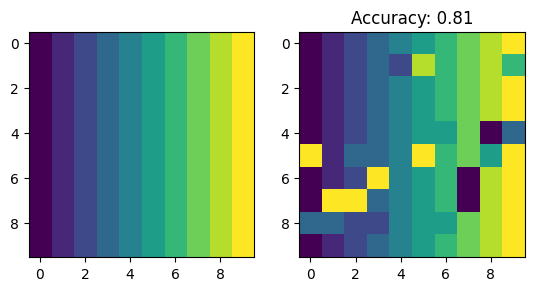

In [ ]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

print(masked_labels)
print(predicted_labels)
print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 50 images per person

Accuracy =  0.632
[ 0.  0.  3.  0.  0.  0.  0.  0.  9.  0.  0.  0.  3.  4.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  7.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  3.  0.
  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  0.  0.  0.
  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  7.  8.  0.  0.  1.  0. 

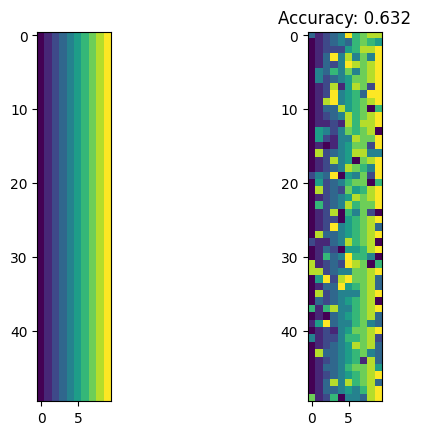

In [ ]:
# # 50 images per person
params_face_rec['k'] = 10
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
# plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
# plot_image_data(images_a)
# print(images_a.shape)
# print(masked_labels_a.reshape(-1, 10))

# graph Laplacian
L_a = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a, soft=True, **params_face_rec)
accuracy_a = np.equal(predicted_labels_a, labels_a).mean()
print("Accuracy = ", accuracy_a)

print(masked_labels_a)
print(predicted_labels_a)
print(labels_a)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy_a))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

Below are some example frames captured during online face recognition. In these frames, the detected faces are outlined and annotated with the predicted labels.

**Some training faces:**

![Online Face Recognition Frame 1](data/faces/Donald/img_2.bmp)
![Online Face Recognition Frame 2](data/faces/Julien/img_6.bmp)

**Some test faces:**

![Online Face Recognition Frame 3](results/frame1.png)
![Online Face Recognition Frame 4](results/frame2.png)
    
### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.

**Approach:**  
After computing the HFS solution for the current face, I obtain a score for each known label. To decide whether to assign a known label or mark the face as unknown, I use a **thresholding strategy**. Specifically:

- **Thresholding:**  
  If the highest score among the predicted label scores is below a predefined threshold (e.g., 0.5), the face is considered too dissimilar to any known centroids, and I label it as **"unknown"**.  
- **Implementation:**  
  In the `online_ssl_compute_solution` function, after computing the scores, if the maximum score is lower than the threshold, I return:
  
  ```python
  return [("unknown", max_score)]
  ```
  
**Example:**  
If in one of the test cases, a new face would yield the following scores:
  
```python
[("Donald", 0.42), ("Julien", 0.38)]
```
  
Since the maximum score (0.42) was below the threshold of 0.5, the system would correctly label the face as **"unknown"**.

![Unknown Face Example](results/frame.png)

*Note: Replace the image link with your actual frame where the unknown face is correctly detected.*

---


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [9]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = None
params_online_ssl['c_u'] = None

In [10]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50, unknown_threshold=0.5):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
        
        # Threshold for unknown faces
        self.unknown_threshold = unknown_threshold
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """
            c_rep, c_add = None, None

            #####
            # --- Find the two closest centroids (c1, c2) with at least one non-taboo ---
            # (Distances between labeled pairs are already set to infinity)
            min_index = np.argmin(self.centroids_distances)
            i, j = np.unravel_index(min_index, self.centroids_distances.shape)

            # Determine c_rep and c_add
            if self.taboo[i] and not self.taboo[j]:
                c_rep, c_add = i, j
            elif self.taboo[j] and not self.taboo[i]:
                c_rep, c_add = j, i
            elif (not self.taboo[i]) and (not self.taboo[j]):
                # Both are non-taboo: choose the one with larger multiplicity as representative
                if self.V[i] >= self.V[j]:
                    c_rep, c_add = i, j
                else:
                    c_rep, c_add = j, i
            else:
                # In the unlikely event both are taboo, force a merge (should not occur due to initialization)
                c_rep, c_add = i, j
                
            """
            Update data structures: self.centroids and self.V
            """

            # --- Merge centroids: update c_rep as the weighted average of the two ---
            merged_centroid = (self.centroids[c_rep] * self.V[c_rep] + self.centroids[c_add] * self.V[c_add]) / (self.V[c_rep] + self.V[c_add])
            self.centroids[c_rep] = merged_centroid
            self.V[c_rep] += self.V[c_add]

            # --- Replace the centroid at index c_add with the new sample ---
            self.centroids[c_add] = face
            self.V[c_add] = 1
            self.Y[c_add] = 0  # New face is initially unlabeled

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])
            ####
            self.last_face = self.centroids.shape[0] - 1
            ####

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        
        # Build the similarity graph on the centroids
        # W = build_similarity_graph(self.centroids, var=params_online_ssl['var'], 
        #                            eps=params_online_ssl['eps'], k=params_online_ssl['k'])
        
        # Build the regularized Laplacian using the centroids as data points
        Q = build_laplacian_regularized(self.centroids, 
                                        laplacian_regularization=params_online_ssl['laplacian_regularization'], 
                                        var=params_online_ssl['var'], 
                                        eps=params_online_ssl['eps'], 
                                        k=params_online_ssl['k'], 
                                        laplacian_normalization=params_online_ssl['laplacian_normalization'])
        
        # W = ...
        # L = ...
        # Q = ...   # regularized Laplacian

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
        
        # handle unknown faces
        # ...
        
        best_label, best_score = max(label_scores, key=lambda x: x[1])
        if best_score < self.unknown_threshold:
            return [("unknown", best_score)]

        return label_scores
      


In [17]:
create_user_profile('Julien')         # choose your names here :)
create_user_profile('Donald', video_filename='data/trump.mp4')
# online_face_recognition(['bob', 'alice'], IncrementalKCenters, n_pictures=15)

New profile created at path data/faces\Julien
Image 1 saved at data/faces\Julien\img_1.bmp
Image 2 saved at data/faces\Julien\img_2.bmp
Image 3 saved at data/faces\Julien\img_3.bmp
Image 4 saved at data/faces\Julien\img_4.bmp
Image 5 saved at data/faces\Julien\img_5.bmp
Image 6 saved at data/faces\Julien\img_6.bmp
Image 7 saved at data/faces\Julien\img_7.bmp
Image 8 saved at data/faces\Julien\img_8.bmp
Image 9 saved at data/faces\Julien\img_9.bmp
Image 10 saved at data/faces\Julien\img_10.bmp
Image 11 saved at data/faces\Julien\img_11.bmp
Image 12 saved at data/faces\Julien\img_12.bmp
Image 13 saved at data/faces\Julien\img_13.bmp
Image 14 saved at data/faces\Julien\img_14.bmp
Image 15 saved at data/faces\Julien\img_15.bmp
Image 16 saved at data/faces\Julien\img_16.bmp
Image 17 saved at data/faces\Julien\img_17.bmp
Image 18 saved at data/faces\Julien\img_18.bmp
Image 19 saved at data/faces\Julien\img_19.bmp
Image 20 saved at data/faces\Julien\img_20.bmp
Image 21 saved at data/faces\Jul

In [26]:
online_face_recognition(['Julien', 'Donald'], IncrementalKCenters, n_pictures=15)

Profile found with 30 images.
Profile found with 41 images.
saved
Image saved at results\frame.png


KeyboardInterrupt: 

In [22]:
online_face_recognition(['Julien', 'Donald'], IncrementalKCenters, n_pictures=15, video_filename='data/trump.mp4')

Profile found with 30 images.
Profile found with 41 images.
saved
Image saved at results\frame.png


KeyboardInterrupt: 

In [29]:
online_face_recognition(['Julien', 'Donald'], IncrementalKCenters, n_pictures=15)

Profile found with 30 images.
Profile found with 41 images.
saved
Image saved at results\frame.png


KeyboardInterrupt: 

In [13]:
online_face_recognition(['Julien', 'Donald'], IncrementalKCenters, n_pictures=15)

Profile found with 30 images.
Profile found with 41 images.


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


: 

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

To allow the system to **dynamically create new classes**, modify the algorithm as follows:  

1. **Store Unknown Faces in a Buffer:**  
   - When a face is classified as **"unknown"**, add it to an **unknown cluster pool**.  
   - If a similar unknown face appears later (based on feature distance), merge it into an existing cluster.  

2. **Track Frequency of Unknown Faces:**  
   - Maintain a **counter** for each unknown cluster, counting how many times similar faces have been observed.  
   - Define a **time decay factor** so that occasional appearances do not accumulate indefinitely.  

3. **Threshold-Based Promotion to a New Class:**  
   - If an unknown cluster **reaches a predefined occurrence threshold** (e.g., observed 10 times within a time window), promote it to a new class.  
   - Assign it an **automatic label** (e.g., "AutoBob") and treat it as a new known class.  

4. **Update Graph and HFS Propagation:**  
   - Once promoted, the system updates the **label vector \( Y \)** to include the new class.  
   - The similarity graph and HFS solution are recomputed to integrate the new class for future predictions.  

**Final Outcome:**  
New individuals are automatically added to the model **only when they appear frequently enough**, preventing overfitting to one-time detections.
    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

### **Results Summary: Supervised vs. Semi-Supervised (HFS) & Inductive vs. Transductive**  

#### **Experiment Setup:**  
- **Dataset:** Augmented face dataset (50 images per person).  
- **Training/Test Split:**  
  - **Labeled set:** \( l = 4 \) labeled faces per class.  
  - **Unlabeled set:** \( u \) faces (80% used for training, 20% for testing).  
  - **Test set:** Remaining 20% of \( u \).  
- **Models:**  
  - **HFS (Semi-Supervised)**
  - **Random Forest (Supervised on \( l \) labeled faces)**  

#### **Results:**

| Model | Train Accuracy | Test Accuracy |
|--------|---------------|--------------|
| **HFS (Semi-Supervised)** | 52.4% (Transductive) | 48.9% (Inductive) |
| **Random Forest (Supervised)** | 100% | 52.2% |

#### **Key Observations:**  
- **Supervised RF performs perfectly on labeled data** but struggles to generalize to unseen test faces, as the number of labeled data do not seem to be enough for the supervised learner to generalize well.  
- **HFS propagates labels well (transductive)** but has slightly lower test accuracy than RF, likely due to suboptimal graph structure.  
- **Semi-supervised learning helps when labeled data is limited**, but improvements depend on a well-structured similarity graph.  
- **Inductive HFS accuracy is lower than transductive**, confirming that HFS is primarily a transductive method.  


In [18]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 10000.0
params_face_rec['eps'] = None
params_face_rec['k'] = 10
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 1.0
params_face_rec['c_u'] = 1e-3

In [19]:
# # 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image, l=4)
# plot_image_data_augmented(images_a)

# step 1: separate train and test indices
non_masked_indices = np.where(masked_labels_a != 0)[0]
l = len(non_masked_indices)
masked_indices= np.where(masked_labels_a == 0)[0]
u = int(0.8*len(masked_indices))
np.random.shuffle(masked_indices)
train_indices = np.concatenate((non_masked_indices, masked_indices[:u]))
test_indices = masked_indices[u:]


# graph Laplacian
L_a = build_laplacian_regularized(images_a[train_indices], 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f_a = compute_hfs(L_a, masked_labels_a[train_indices], soft=True, **params_face_rec)
accuracy_a = np.equal(predicted_labels_a, labels_a[train_indices]).mean()
print("Accuracy train set HFS = ", accuracy_a)

masked_labels_a_new = masked_labels_a.copy()
masked_labels_a_new[train_indices] = predicted_labels_a

L_a_new = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
predicted_labels_a_new, f_a = compute_hfs(L_a_new, masked_labels_a_new, soft=True, **params_face_rec)

accuracy_a_new = np.equal(predicted_labels_a_new[test_indices], labels_a[test_indices]).mean()
print("Accuracy test set HFS = ", accuracy_a_new)



Accuracy train set HFS =  0.5245098039215687
Accuracy test set HFS =  0.4891304347826087


In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(images_a[non_masked_indices], masked_labels_a[non_masked_indices])

accuracy_test_rf = model.score(images_a[test_indices], labels_a[test_indices])
accuracy_train_rf = model.score(images_a[non_masked_indices], masked_labels_a[non_masked_indices])
print(f"accuracy train set with RF: {accuracy_train_rf}")
print(f"accuracy test set with RF: {accuracy_test_rf}")


accuracy train set with RF: 1.0
accuracy test set with RF: 0.5217391304347826
